# Heartbeat Classification with Machine Learning

### Loading and Exploring Heartbeat dataset

We have heartbeat dataset. To analyze this dataset, we need to incorporate time sequence along with the audio signals to capture the underlying patterns. We will load the dataset with libroas. First, let us cisualize how a sample audio data looks when sound amplitude is plotted against time

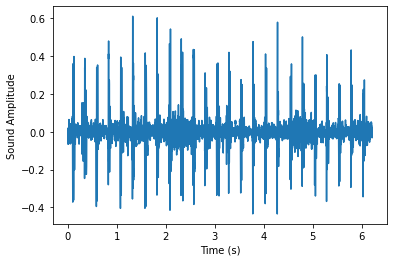

In [1]:

data_dir = 'dataset/kaggle/normal'
import librosa as lr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

# List all the wav files in the folder
audio_files = glob(data_dir + '/*.wav')

# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

In [2]:
print(sfreq)
print(len(audio))
audio

22050
136925


array([-0.03442627, -0.04003989, -0.04242501, ...,  0.0022146 ,
        0.00193785,  0.00121363], dtype=float32)

Let us create a helper function to load the two datasets into two dataframes: `normal` and `abnormal`

In [3]:
import os
import pandas as pd

# Function to load audio files and create a DataFrame
def load_audio_files_to_df(folder_path):
    # List all .wav files in the folder
    audio_files = glob(folder_path + '/*.wav')
    
    # Initialize a list to hold the loaded audio data
    audio_data_list = []

    # Load each audio file
    for file in audio_files:
        # Load the audio file
        audio, sr = lr.load(file, sr=None)
        audio_data_list.append(audio)
    
    # Find the maximum length of the audio files
    max_length = max(len(audio) for audio in audio_data_list)

    # Pad shorter audio files with zeros to match the maximum length
    padded_audio_data_list = [np.pad(audio, (0, max_length - len(audio)), 'constant') for audio in audio_data_list]

    # Convert the list to a NumPy array and then to a DataFrame
    audio_data_array = np.array(padded_audio_data_list).T
    df = pd.DataFrame(audio_data_array)
    
    return df, sr

Now let us use this helper function to create the two dataframes. 

In [4]:


# Load normal heartbeat audio files into a DataFrame
normal_dir = 'dataset/kaggle/normal'
normal, sfreq = load_audio_files_to_df(normal_dir)

# Load abnormal heartbeat audio files into a DataFrame
abnormal_dir = 'dataset/kaggle/abnormal'
abnormal, _ = load_audio_files_to_df(abnormal_dir) 


# Print the shape of the DataFrames
print('Normal DataFrame shape:', normal.shape)
print('Abnormal DataFrame shape:', abnormal.shape)

Normal DataFrame shape: (396900, 231)
Abnormal DataFrame shape: (396900, 165)


Let us see some samples from the two dataframes

In [6]:

# Display the first few rows of the DataFrames
print(normal.head())


        0         1         2         3         4         5         6    \
0 -0.036987  0.065216  0.007416  0.017670 -0.003784  0.012787  0.024139   
1 -0.036987  0.061340  0.008209  0.016113  0.001526  0.010345  0.029510   
2 -0.036591  0.062347  0.005188  0.013550  0.008118  0.014465  0.032990   
3 -0.023895  0.072113  0.001129  0.010162  0.000366  0.018158  0.033752   
4 -0.014160  0.071167  0.003784  0.007446  0.001404  0.008423  0.046265   

        7         8         9    ...       221       222       223       224  \
0 -0.019409  0.059753 -0.000793  ... -0.029694  0.010315  0.011230 -0.060669   
1 -0.019836  0.062378  0.001526  ... -0.025116 -0.000153  0.007446 -0.049591   
2 -0.009552  0.070190  0.000092  ...  0.009186 -0.009918  0.002869 -0.024780   
3 -0.004578  0.067902 -0.002380  ...  0.010132 -0.016357  0.006989 -0.010040   
4 -0.016663  0.066315  0.004639  ... -0.045624 -0.016602  0.013306 -0.012848   

        225       226       227       228       229       230  
0  0

In [8]:

# Display the first few rows of the DataFrames
print(abnormal.head())

        0         1         2         3         4         5         6    \
0  0.001129  0.000000  0.000000 -0.005096  0.014496  0.006714 -0.004761   
1  0.000763  0.000427  0.000000 -0.006012  0.014099  0.005829 -0.004486   
2  0.000854  0.000549  0.000244 -0.006439  0.013489  0.005219 -0.004456   
3  0.000854  0.000000  0.000031 -0.005890  0.014130  0.004211 -0.004242   
4  0.000153 -0.000092  0.000153 -0.005737  0.014221  0.006165 -0.004181   

        7         8         9    ...       155       156       157       158  \
0 -0.000275 -0.000275 -0.000366  ...  0.007843 -0.001221  0.077423  0.007782   
1 -0.000397 -0.000305 -0.000305  ...  0.003967 -0.002930 -0.005981  0.005585   
2 -0.000275 -0.000458  0.000183  ...  0.016846 -0.004730 -0.048676  0.004150   
3 -0.000244 -0.000275  0.000092  ...  0.013275 -0.001282 -0.084991  0.005005   
4 -0.000031 -0.000305  0.000458  ...  0.009888 -0.000244 -0.154144  0.000946   

        159       160       161       162       163       164  
0  0

Each column represents time series from a sample data. In `normal` dataframe, samples from normal heartbeat are loaded, whereas in  `abnormal` dataframe, samples from abnormal heartbeat are loaded. Let us visualize how normal and abnormal sample differs from each other. First we will create a helper function for the visualization

In [19]:
   
# Function to show plot and set titles
def show_plot_and_make_titles(ax0, ax1):
    ax0.set(title="Normal Heartbeats")
    ax1.set(title="Abnormal Heartbeats")
    plt.tight_layout()
    plt.show()


Now let us use this helper function to visualize 1 sample from both dataset

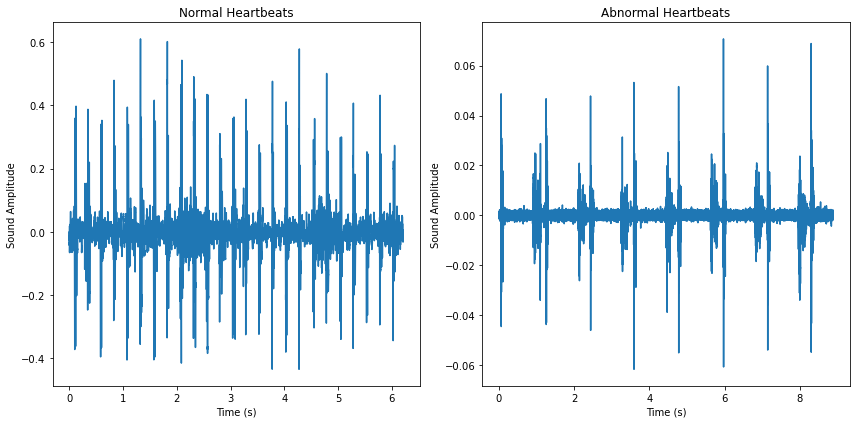

In [20]:


# Read in the first audio file from each folder for plotting
normal_audio, normal_sfreq = lr.load(glob(normal_dir + '/*.wav')[0])
abnormal_audio, abnormal_sfreq = lr.load(glob(abnormal_dir + '/*.wav')[0])

# Create time arrays for plotting
normal_time = np.arange(0, len(normal_audio)) / normal_sfreq
abnormal_time = np.arange(0, len(abnormal_audio)) / abnormal_sfreq

# Create subplots for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot normal heartbeat audio
axs[0].plot(normal_time, normal_audio)
axs[0].set(xlabel='Time (s)', ylabel='Sound Amplitude')

# Plot abnormal heartbeat audio
axs[1].plot(abnormal_time, abnormal_audio)
axs[1].set(xlabel='Time (s)', ylabel='Sound Amplitude')


# Call the function to display the plots with titles
show_plot_and_make_titles(axs[0], axs[1])


Let us mean across the datasets and see how the result looks.

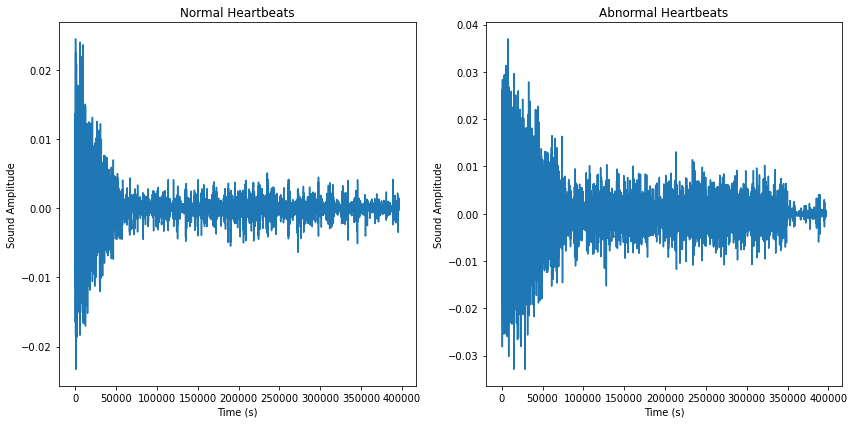

In [21]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)


# Create subplots for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot mean normal heartbeat audio
axs[0].plot( mean_normal)
axs[0].set(xlabel='Time (s)', ylabel='Sound Amplitude')

# Plot mean abnormal heartbeat audio
axs[1].plot( mean_abnormal)
axs[1].set(xlabel='Time (s)', ylabel='Sound Amplitude')


# Call the function to display the plots with titles
show_plot_and_make_titles(axs[0], axs[1])


From the visualization above, we get the intuition that abnormal heartbeats have more standard deviation (almost twice) than normal ones. Since normal heartbeats are rhythmic beats, this gives us the initial intuition that out of sync heartbeats are abnormal heartbeats.

### Preparing data for modeling

We will now create a linear model for classification task of normal and abnormal heartbeat. Before that, we need to modify the dataframes by transposing them. This is because, currently we have each sample as a column in the dataset. We need to make it so that each sample time series is recorded in a row. Also, we will assign category to them while doing so (normal samples will be labeled as 0 and abnormal samples will be labeled as 1). After that we will merge them together.

In [22]:

# Transpose the DataFrames to have the shape (no_samples, time_series)
normal = normal.T
abnormal = abnormal.T

# Add a new column "category" with values 0 for normal and 1 for abnormal
normal['category'] = 0
abnormal['category'] = 1

# Merge the DataFrames vertically
combined_df = pd.concat([normal, abnormal], ignore_index=True)

Now we need to split the dataset into training set and testing set. We will train the classifier with training set and then see how it performs in testing set.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


# Split into features (X) and labels (y)
X = combined_df.drop('category', axis=1)
y = combined_df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Creating a linear clasifier model


Now let us use the Support vector classifier (SVC) to train a linear model

In [24]:

# Train an SVC
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Let us evaluate how this simple model performs

In [25]:

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


Accuracy: 0.7
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        53
           1       0.59      0.37      0.45        27

    accuracy                           0.70        80
   macro avg       0.66      0.62      0.62        80
weighted avg       0.68      0.70      0.68        80



### Creating a deep learning model

Before creating a deep learning model, we need to prepare the dataset so that we can feed the neural network our data samples. While we are at it, we will create a helper function to later experiment how skipping every n-samples in time series can affect the model's performance.

In [26]:
from scipy.signal import resample

# # Function to downsample the data by resampling
# def downsample_data(X, target_length):
#     X_downsampled = np.array([resample(x, target_length) for x in X.values])
#     return X_downsampled

# # Target length after downsampling
# target_length = 3969

# # Downsample the data
# X_downsampled = downsample_data(X, target_length)

# Function to downsample the data by taking every n-th value
def downsample_data(X, step):
    X_downsampled = np.array([x[::step] for x in X.values])
    return X_downsampled

# Downsample the data
X_downsampled = downsample_data(X, step=1)

# Split the downsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y, test_size=0.2, random_state=42, stratify=y)

# Reshape the data to fit the neural network input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (316, 396900, 1)
X_test shape: (80, 396900, 1)


Let us now build the neural network. We will use Conv1D (1-dimensional convolutional layers) with time series data because it is advantageous due to its efficiency in captures patterns and features within the temporal sequences. It will help us to: 
1. Capturing Local Patterns Time series data in each filter can learn different features, such as trends, cycles, and seasonality, by sliding over the sequence. 
2. Temporal Invariance helps to detect features regardless of their position in the sequence.
3. Parameter Sharing In Conv1D let the same set of weights (filters) is used across the entire time series thatreduces the number of parameters, making the model more efficient and less prone to overfitting compared to fully connected layers. 
4. Hierarchical Feature Learning By stacking multiple Conv1D layers. Deeper layers can combine simple patterns of previous layers to detect more complex features and long-term dependencies. 
5. Computational Efficiency compared to RNNs or LSTMs because they can be parallelized more easily. 

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

target_length = X_train.shape[1]

# Define the model
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(target_length, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 396898, 16)        64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198449, 16)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198447, 32)        1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99223, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3175136)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                203208768 
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

Let us now use this model to train and then evaluate.

In [29]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

Epoch 1/10
8/8 [==============================] - 44s 6s/step - loss: 0.9248 - accuracy: 0.5992 - val_loss: 0.6435 - val_accuracy: 0.5469
Epoch 2/10
8/8 [==============================] - 51s 6s/step - loss: 0.5238 - accuracy: 0.7857 - val_loss: 0.6122 - val_accuracy: 0.6719
Epoch 3/10
8/8 [==============================] - 43s 5s/step - loss: 0.4034 - accuracy: 0.8294 - val_loss: 0.6642 - val_accuracy: 0.6250
Epoch 4/10
8/8 [==============================] - 44s 6s/step - loss: 0.2779 - accuracy: 0.9087 - val_loss: 0.7767 - val_accuracy: 0.5938
Epoch 5/10
8/8 [==============================] - 45s 6s/step - loss: 0.2194 - accuracy: 0.9206 - val_loss: 0.8227 - val_accuracy: 0.6562
Epoch 6/10
8/8 [==============================] - 46s 6s/step - loss: 0.1417 - accuracy: 0.9484 - val_loss: 0.8933 - val_accuracy: 0.6562
Epoch 7/10
8/8 [==============================] - 43s 5s/step - loss: 0.0971 - accuracy: 0.9643 - val_loss: 1.0887 - val_accuracy: 0.6094
Epoch 8/10
8/8 [==================

Let us visualize how the model performs

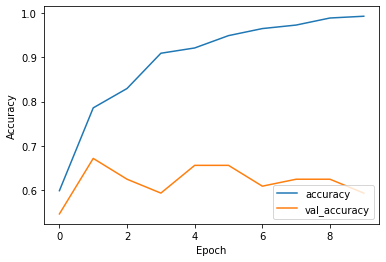

In [30]:

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

The visualization shows after first epoch, there is a clear sign of overfitting. After 5th epoch, the performance starts declining. While comparing the linear classifier with the deep learning model. The linear classifier performs way better in terms of training computation and time efficiency. Linear classifier gave us 70% accuracy on test data whereas deep learning model gave us around 64% accuracy.

### Cutting off later time-frames

Now we will revisit the dataset and see if taking portion from earlier time-series can make any difference in model performance and how much the performance is affected

In [32]:
# Function to load audio files and create a DataFrame
def load_audio_files_to_df(folder_path):
    # List all .wav files in the folder
    audio_files = glob(folder_path + '/*.wav')
    
    # Initialize a list to hold the loaded audio data
    audio_data_list = []

    # Load each audio file
    for file in audio_files:
        # Load the audio file
        audio, sr = lr.load(file, sr=None)
        audio_data_list.append(audio)
    
    # Find the maximum length of the audio files
    max_length = max(len(audio) for audio in audio_data_list)

    # Pad shorter audio files with zeros to match the maximum length
    padded_audio_data_list = [np.pad(audio, (0, max_length - len(audio)), 'constant') for audio in audio_data_list]

    # Convert the list to a NumPy array and then to a DataFrame
    audio_data_array = np.array(padded_audio_data_list).T
    df = pd.DataFrame(audio_data_array)
    
    return df, sr

# Load normal heartbeat audio files into a DataFrame
normal_dir = 'dataset/kaggle/normal'
normal, sfreq = load_audio_files_to_df(normal_dir)

# Load abnormal heartbeat audio files into a DataFrame
abnormal_dir = 'dataset/kaggle/abnormal'
abnormal, _ = load_audio_files_to_df(abnormal_dir)


Let us visualize a single sample

(396900, 231)


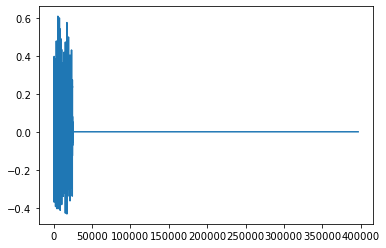

In [33]:
print(normal.shape)
normal[0].plot()
plt.show()

We can clearly see that there is a huge portion of data on the right which is empty. This is because not all audio data are recorded in same time-frames. While importing and merging the two datasets, in order to maintain the consistency and avoid data loss, the audio data with less time-frames were zero-padded in order to combine with audio data with more time-frames. We will take up to 30,000 points in X-axis for all data and cut off the rest

In [34]:
normal = normal.iloc[:30000]
abnormal = abnormal.iloc[:30000]
print(normal.shape)
print(abnormal.shape)


(30000, 231)
(30000, 165)


Let us now see how the samples from normal and abnormal data looks

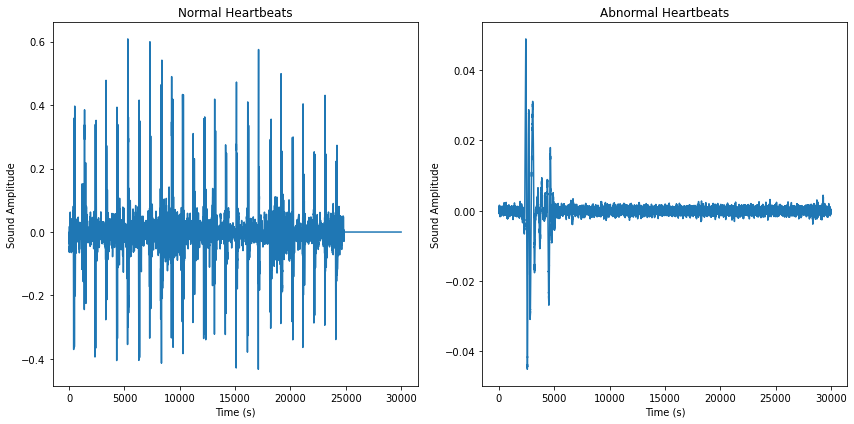

In [37]:

# Create subplots for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot mean normal heartbeat audio
axs[0].plot( normal[0])
axs[0].set(xlabel='Time (s)', ylabel='Sound Amplitude')

# Plot mean abnormal heartbeat audio
axs[1].plot( abnormal[0])
axs[1].set(xlabel='Time (s)', ylabel='Sound Amplitude')


# Call the function to display the plots with titles
show_plot_and_make_titles(axs[0], axs[1])

Let us now again pre-process the dataset like before and then split the dataset into training and testing set

(396, 30001)


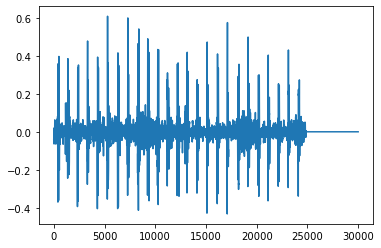

In [38]:

# Transpose the DataFrames to have the shape (no_samples, time_series)
normal = normal.T
abnormal = abnormal.T

# Add a new column "category" with values 0 for normal and 1 for abnormal
normal['category'] = 0
abnormal['category'] = 1

# Merge the DataFrames vertically
combined_df = pd.concat([normal, abnormal], ignore_index=True)


print(combined_df.shape)
combined_df.iloc[0,:-1].plot()
plt.show()

In [39]:

# Split into features (X) and labels (y)
X = combined_df.drop('category', axis=1)
y = combined_df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(316, 30000)
(80, 30000)
(316,)
(80,)


### Training a new Linear Classifier

We will now train a new Support Vector Classifier (SVC) and see how it performs with the new data

In [40]:

# Train a new SVC
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


Accuracy: 0.5875
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70        53
           1       0.36      0.30      0.33        27

    accuracy                           0.59        80
   macro avg       0.52      0.52      0.51        80
weighted avg       0.57      0.59      0.58        80



### Training new Neural Network Classifier

We will now create another neural network model to see the performance on modified data

In [41]:
from scipy.signal import resample

# # Function to downsample the data
# def downsample_data(X, target_length):
#     X_downsampled = np.array([resample(x, target_length) for x in X.values])
#     return X_downsampled

# # Target length after downsampling
# target_length = 3969

# # Downsample the data
# X_downsampled = downsample_data(X, target_length)

# Function to downsample the data by taking every nth value
def downsample_data(X, step):
    X_downsampled = np.array([x[::step] for x in X.values])
    return X_downsampled

# Downsample the data
X_downsampled = downsample_data(X, step=1)

# Split the downsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y, test_size=0.2, random_state=42, stratify=y)

# Reshape the data to fit the neural network input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (316, 30000, 1)
X_test shape: (80, 30000, 1)


In [42]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

target_length = X_train.shape[1]

# Define the model
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(target_length, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')



Epoch 1/10
8/8 [==============================] - 4s 459ms/step - loss: 0.7812 - accuracy: 0.5357 - val_loss: 0.7534 - val_accuracy: 0.5781
Epoch 2/10
8/8 [==============================] - 3s 410ms/step - loss: 0.4545 - accuracy: 0.7817 - val_loss: 0.7113 - val_accuracy: 0.6875
Epoch 3/10
8/8 [==============================] - 3s 375ms/step - loss: 0.3259 - accuracy: 0.8889 - val_loss: 0.7993 - val_accuracy: 0.6406
Epoch 4/10
8/8 [==============================] - 3s 357ms/step - loss: 0.2344 - accuracy: 0.9127 - val_loss: 0.9627 - val_accuracy: 0.5938
Epoch 5/10
8/8 [==============================] - 4s 469ms/step - loss: 0.1452 - accuracy: 0.9524 - val_loss: 1.1812 - val_accuracy: 0.5781
Epoch 6/10
8/8 [==============================] - 3s 397ms/step - loss: 0.0920 - accuracy: 0.9643 - val_loss: 1.4289 - val_accuracy: 0.5938
Epoch 7/10
8/8 [==============================] - 3s 435ms/step - loss: 0.0582 - accuracy: 0.9762 - val_loss: 1.6646 - val_accuracy: 0.5938
Epoch 8/10
8/8 [====

Previously, we have seen a sign of overfitting while training with previous data. Let us see how training looks on modified data

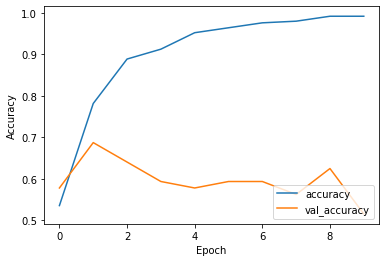

In [43]:

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

While the problem of overfitting still exists, we see that the performance of the linear model drops from 70% to 58% which is quite significant compared to neural network model's performance, which remains almost constant for both dataset.

### Does Creating simple features help us reduce overfitting?

Since we are still working with large number of features (each time series is consisted of 30000 features), overfitting is to be expected due to the concept of curse of dimensionality. Can we overcome this issue by reducing the number of dimensions while keeping the accuracy consistent? Let us create some features to find out. Let us start by first rectifying the audio signals so that we can compute them on positive values.

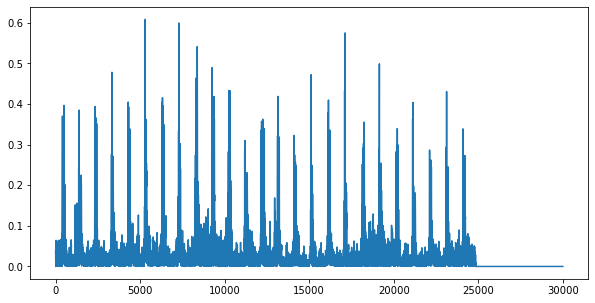

In [44]:
# Rectify the audio signal
X_df = pd.DataFrame(X_downsampled.T)
audio_rectified = X_df.apply(np.abs)

# Plot the result
audio_rectified[0].plot(figsize=(10, 5))
plt.show()

Now let us smoothen the values by taking rolling means. This will also help us reducing the noise that the spikes in values create.

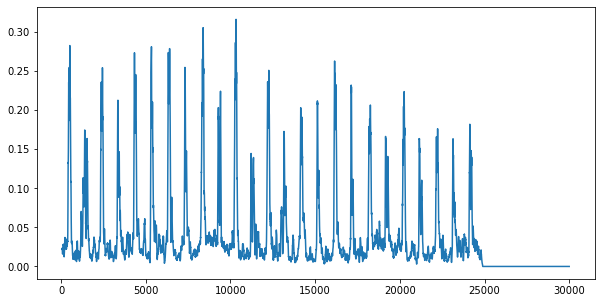

In [45]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean()

# Plot the result
audio_rectified_smooth[0].plot(figsize=(10, 5))
plt.show()

Let us now take this dataset in the shape `(no_samples, no_features)`

In [46]:

audio_rectified_smooth = audio_rectified_smooth.T
audio_rectified_smooth.shape

(396, 30000)

We will now create simple statistical features

In [53]:
# Calculate stats
means = np.mean(audio_rectified_smooth, axis=1)
stds = np.std(audio_rectified_smooth, axis=1)
maxs = np.max(audio_rectified_smooth, axis=1)

# Create the X and y arrays
X = np.column_stack([means, stds, maxs])

X = pd.DataFrame(X)
print(X.shape)
print(type(X))

(396, 3)
<class 'pandas.core.frame.DataFrame'>


Now we will split the dataset into training and testing set

In [54]:
y = combined_df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)


(80, 3)
(316, 3)
(80,)
(316,)


### Updated Linear Classifier Model

We will now see how the normal features help the performance of SVC model

In [55]:

# Train a new SVC
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


Accuracy: 0.6625
Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        53
           1       0.00      0.00      0.00        27

    accuracy                           0.66        80
   macro avg       0.33      0.50      0.40        80
weighted avg       0.44      0.66      0.53        80



C:\Users\88016\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\88016\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\88016\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Updated Neural Network Classifier Model


Let us now look at the deep learning model with these statistical features

In [57]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the target variable to categorical if it's a classification problem
num_classes = len(np.unique(y_train))  # We will keep it open for multi-class problem
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


(80, 3)
(316, 3)
(80,)
(316,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 2,402
Trainable params: 2,402
Non-trainable params: 0
_________________________________________________________________


In [58]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5728 - val_loss: 0.6358 - val_accuracy: 0.7125
Epoch 2/50
32/32 [==============================] - 0s 1ms/step - loss: 0.6541 - accuracy: 0.6424 - val_loss: 0.6206 - val_accuracy: 0.6875
Epoch 3/50
32/32 [==============================] - 0s 1ms/step - loss: 0.6387 - accuracy: 0.6487 - val_loss: 0.6080 - val_accuracy: 0.7000
Epoch 4/50
32/32 [==============================] - 0s 1ms/step - loss: 0.6264 - accuracy: 0.6519 - val_loss: 0.6056 - val_accuracy: 0.7125
Epoch 5/50
32/32 [==============================] - 0s 1ms/step - loss: 0.6171 - accuracy: 0.6519 - val_loss: 0.5948 - val_accuracy: 0.7125
Epoch 6/50
32/32 [==============================] - 0s 1ms/step - loss: 0.6109 - accuracy: 0.6456 - val_loss: 0.5969 - val_accuracy: 0.7125
Epoch 7/50
32/32 [==============================] - 0s 1ms/step - loss: 0.6098 - accuracy: 0.6456 - val_loss: 0.6023 - val_accuracy: 0.6875
Epoch 8/50
32/32 [==

Let us visualize to see if overfitting problem is overcome

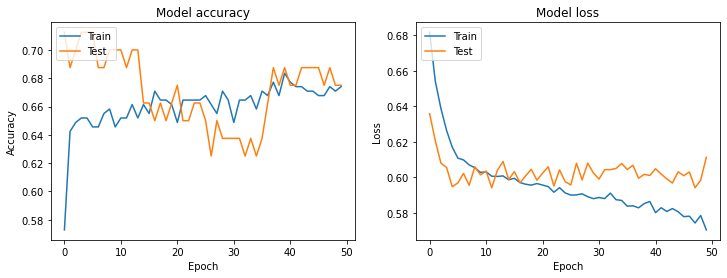

In [59]:

# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


Only 3 features helped us to overcome the problem of overfitting while also keeping the accuracy rate stable. We can clearly see that the accuracy converges on 50 epochs. However, the best model can be taken after 10 epochs of training. Although in this case both the linear model and the deep learning model performed similarly, it is more advantegous to use the linear model for simpler approach.